In [66]:
import pandas as pd
import scanpy as sc
import anndata as ad
from tqdm import tqdm
import cell2cell as c2c
import os
import liana as li
from cell2cell.preprocessing import aggregate_single_cells 
from collections import defaultdict

In [9]:
# load the data object
adata = sc.read_h5ad("/home/jmitchel/data/temp_test_data/lupus_subsetted_seurat_v3_for_scanpy.h5ad")


In [23]:
print(adata.obs.head())

                                                             batch_cov  \
CTAACTTCAATGAATG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-...  dmx_YS-JY-22_pool6   
GGCTCGATCGTTGACA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-...  dmx_YS-JY-20_pool3   
CCACCTAAGGGCTTCC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-...  dmx_YS-JY-22_pool5   
GTCACGGAGATTACCC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-...          dmx_YE_8-2   
TGACAACAGAATTCCC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-...         dmx_YE_7-20   

                                                      ind_cov  \
CTAACTTCAATGAATG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-...  1132_1132   
GGCTCGATCGTTGACA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-...  1110_1110   
CCACCTAAGGGCTTCC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-...  1333_1333   
GTCACGGAGATTACCC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-...  1368_1368   
TGACAACAGAATTCCC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-...  1197_1197   

                                                   Processing_Cohort  louvain  \
CTAACTTCAATGAATG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-...                L3        7   
GG

In [11]:
adata.obs["cg_cov"] = pd.Series(adata.obs["cg_cov"], dtype='category')

In [12]:
adata.obs["cg_cov"].cat.categories

Index(['B', 'NK', 'PB', 'Progen', 'Prolif', 'Tc', 'Th', 'cDC', 'cMono',
       'ncMono', 'pDC'],
      dtype='object')

In [13]:
# subset data to cell types also used in scITD analysis
adata = adata[adata.obs['cg_cov'].isin(["B","NK","Th","Tc","cDC","cMono","ncMono"])]

In [15]:
sample_key = 'ind_cov_batch_cov'
condition_key = 'SLE_status'
groupby = 'cg_cov'

In [16]:
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/jmitchel/miniconda3/envs/sandbox/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.


In [17]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby=groupby,
    sample_key=sample_key, # sample key by which we which to loop
    use_raw=False,
    verbose=True, # use 'full' to show all verbose information
    n_perms=100, # reduce permutations for speed
    return_all_lrs=True, # return all LR values
    )

Converting `ind_cov_batch_cov` to categorical!
Now running: 1004_1004:dmx_YE_7-13:   0%|               | 0/136 [00:00<?, ?it/s]/home/jmitchel/miniconda3/envs/sandbox/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
Now running: 1014_1014:dmx_YS-JY-22_pool5:   1%| | 1/136 [00:06<15:00,  6.67s/it/home/jmitchel/miniconda3/envs/sandbox/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
Now running: 1015_1015:dmx_YS-JY-20_pool4:   1%| | 2/136 [00:12<13:13,  5.92s/it/home/jmitchel/miniconda3/envs/sandbox/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
Now running: 1031_1031:dmx_YE_7-13:   4%|▎      | 5/136 [00:33<14:48,  6.78s/it]/home/jmitchel/

In [18]:
adata.uns["liana_res"].sort_values("magnitude_rank").head(10)

,ind_cov_batch_cov,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank
558296,1046_1046:dmx_YE_7-13,cMono,cMono,S100A9,ITGB2,2.312496,0.0,3.589198,1.564312,2.713204,0.086039,0.979666,4.319342e-07,4.016890e-09
3098603,1251_1251:dmx_YE_7-26,Tc,NK,B2M,KLRD1,2.311096,0.0,2.743186,1.352175,0.947636,0.104585,0.974496,7.866733e-07,4.652390e-09
8021112,1785_1785:dmx_YE_8-16,cMono,cMono,S100A9,ITGB2,2.403029,0.0,3.579028,0.938412,2.741604,0.093090,0.977062,7.001955e-07,4.841153e-09
8582198,1848_1848:dmx_YE_8-17,NK,NK,B2M,KLRD1,2.420676,0.0,3.624712,1.670042,1.300724,0.130136,0.977615,3.428097e-07,4.852626e-09
1342590,1119_1119:dmx_YE_7-19,cMono,NK,S100A9,ITGB2,2.444128,0.0,4.451901,1.166311,2.748800,0.104850,0.978379,1.233427e-06,4.874446e-09
3547149,1281_1281:dmx_YE_7-26,NK,NK,B2M,KLRD1,2.383211,0.0,3.486544,1.807612,1.016317,0.123421,0.977821,1.182537e-06,5.058149e-09
1057165,1078_1078:dmx_YS-JY-20_pool4,NK,NK,B2M,KLRD1,2.541953,0.0,3.600127,1.964628,0.975311,0.106457,0.978586,4.555556e-07,5.069319e-09
4065128,1325_1325:dmx_YS-JY-22_pool5,NK,NK,B2M,KLRD1,2.422570,0.0,3.129330,1.182703,0.806633,0.104093,0.978236,2.262650e-07,5.083183e-09
3467181,1279_1279:dmx_YE_7-26,cMono,NK,S100A9,ITGB2,2.390295,0.0,4.030366,1.176235,2.870580,0.108767,0.978135,1.160849e-06,5.095528e-09
2889912,1248_1248:dmx_YE_7-26,NK,NK,B2M,KLRD1,2.367698,0.0,3.013638,1.419077,0.960940,0.116183,0.975818,9.343632e-07,5.100381e-09


In [19]:
tensor = li.multi.to_tensor_c2c(adata,
                                sample_key=sample_key,
                                score_key='magnitude_rank', # can be any score from liana
                                how='outer_cells' # how to join the samples
                                )

100%|█████████████████████████████████████████| 136/136 [07:01<00:00,  3.10s/it]


In [20]:
tensor.tensor.shape

(136, 500, 7, 7)

In [21]:
# c2c.io.export_variable_with_pickle(tensor, "/home/jmitchel/data/temp_test_data/lupus_subsetted_seurat_v3_for_scanpy_tensor.pkl")

/home/jmitchel/data/temp_test_data/lupus_subsetted_seurat_v3_for_scanpy_tensor.pkl  was correctly saved.


In [26]:
context_dict = adata.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

In [27]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=6, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device='cpu', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=20, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )

Running Tensor Factorization


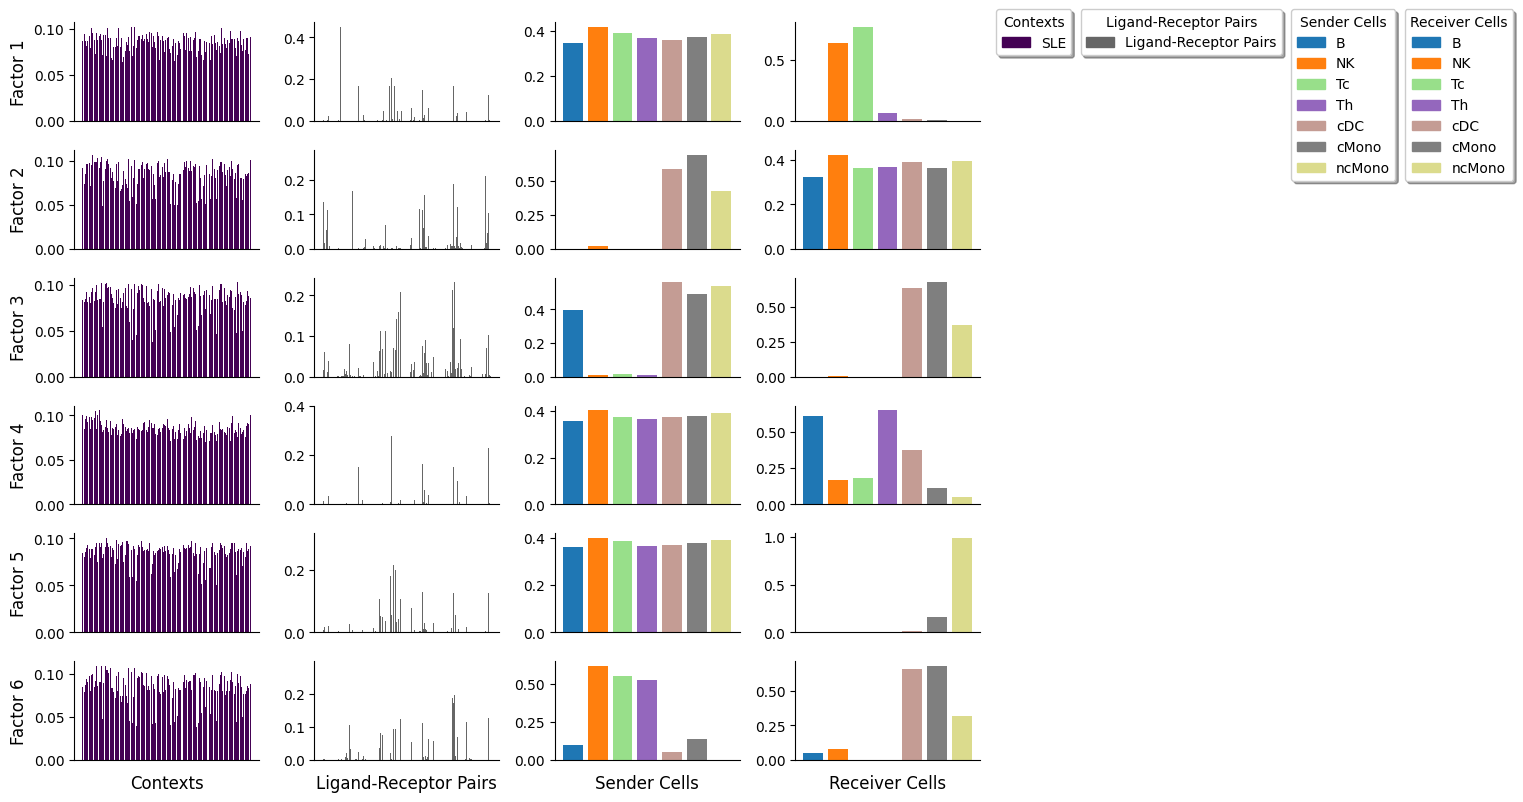

In [28]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = tensor_meta, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['viridis', 'Dark2_r', 'tab20', 'tab20'],
                                                 fontsize=10, # Font size of the figures generated
                                                 )

In [32]:
factors = tensor.factors


In [43]:
lr_loadings = factors['Ligand-Receptor Pairs']
sample_loadings = factors['Contexts']
ct_send_loadings = factors['Sender Cells']
ct_rec_loadings = factors['Receiver Cells']

In [44]:
# ## saving loadings
# lr_loadings.to_csv('/home/jmitchel/data/lupus_data/tensor_c2c_lr_lds.csv')
# sample_loadings.to_csv('/home/jmitchel/data/lupus_data/tensor_c2c_donor_lds.csv')
# ct_send_loadings.to_csv('/home/jmitchel/data/lupus_data/tensor_c2c_ct_send_lds.csv')
# ct_rec_loadings.to_csv('/home/jmitchel/data/lupus_data/tensor_c2c_ct_rec_lds.csv')

In [33]:
factors

OrderedDict([('Contexts',
                                            Factor 1  Factor 2  Factor 3  Factor 4  \
              1004_1004:dmx_YE_7-13         0.086753  0.091444  0.083869  0.100523   
              1014_1014:dmx_YS-JY-22_pool5  0.095190  0.073835  0.081169  0.085095   
              1015_1015:dmx_YS-JY-20_pool4  0.086937  0.085028  0.085231  0.096296   
              1019_1019:dmx_YE_7-13         0.081886  0.096269  0.092817  0.098966   
              1022_1022:dmx_YE_7-13         0.087094  0.096275  0.081643  0.092901   
              ...                                ...       ...       ...       ...   
              1958_1958:dmx_YE_8-23         0.077399  0.085093  0.078354  0.076169   
              1961_1961:dmx_YE_8-23         0.089978  0.083089  0.082627  0.087654   
              2061_2061:dmx_YS-JY-22_pool5  0.090040  0.085027  0.093011  0.091792   
              2082_2082:dmx_YS-JY-20_pool4  0.072366  0.086488  0.087876  0.089973   
              2135_2135:dmx_

In [54]:
adata.uns['liana_res'].shape


(9726887, 14)

In [57]:
# max(adata.uns['liana_res']['cellphone_pvals'])
lr_pairs = adata.uns['liana_res'][['ligand_complex','receptor_complex']]
lr_pairs = lr_pairs.drop_duplicates()
print(lr_pairs.shape)


(3390, 2)


In [64]:
# lr_pairs.to_csv('/home/jmitchel/data/lupus_data/tensor_c2c_LR_pairs.csv')

In [67]:
# adata.uns["liana_res"].to_csv('/home/jmitchel/data/lupus_data/tensor_c2c_LR_tests.csv')